# Classification

This notebook demonstrates how different ML models can represent complex relationships,
Specifically, how the models learn the shape of an A from subsampled points

It covers how to manipulate data using Pandas, how to train a model with Scikit-learn, and how to use the sklearn_pandas to normalise data in a sklearn pipeline.

In [1]:
# !pip install numpy pandas seaborn matplotlib sklearn sklearn_pandas

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 10
sns.set(context='notebook', rc={'figure.figsize': (8, 5)})
from IPython.display import display

In [3]:
dfimg = pd.read_csv('a.csv', header=None)
# Subsample
dfimg = dfimg.iloc[::7, ::7]

In [4]:
dfimg

,0,7,14,21,28,35,42,49,56,63,70,77,84,91,98
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
14,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
21,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1
28,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1
105,1,1,0,0,1,1,1,1,1,1,1,0,0,0,1
112,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1
119,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [5]:
def highlight_zero(s):
    return ['background-color: lightblue' if v == 0 else '' for v in s]

dfimg.style.apply(highlight_zero)

,0,7,14,21,28,35,42,49,56,63,70,77,84,91,98
0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
14,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1
21,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1
28,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1
35,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1
42,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1
49,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1
56,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1
63,1,1,1,1,0,0,0,1,1,1,0,0,1,1,1


In [6]:
df = dfimg.unstack().reset_index()
df.columns = ['a', 'b', 'c']
pd.options.display.max_rows = 10
df

,a,b,c
0,0,0,1
1,0,7,1
2,0,14,1
3,0,21,1
4,0,28,1
...,...,...,...
280,98,98,1
281,98,105,1
282,98,112,1
283,98,119,1


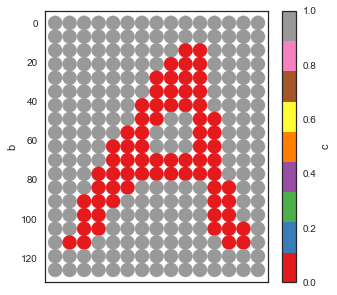

In [7]:
sns.set_style('white')
df.plot.scatter('a', 'b', c='c', cmap='Set1',
                s=200, marker='o', figsize=(5, 5))
plt.gca().invert_yaxis()

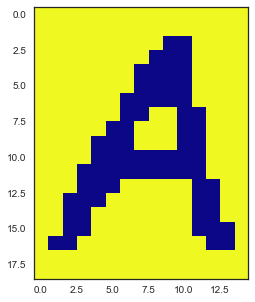

In [8]:
ax = plt.imshow(df.pivot('b', 'a', 'c'), interpolation='none', cmap='plasma')

In [9]:
# Split into train / test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df[['a', 'b']], df[['c']], test_size=0.3, random_state=123)

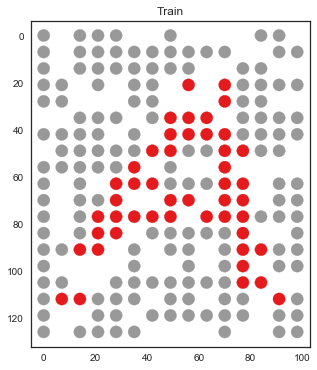

In [10]:
# Visualise training data
plt.figure(figsize=(5, 6))
plt.title('Train')
plt.scatter(x_train.a, x_train.b, c=y_train.c, cmap='Set1', s=150)
plt.gca().invert_yaxis()

In [11]:
y_train

,c
4,1
125,0
202,1
221,0
194,0
...,...
106,0
83,1
17,1
230,1


In [12]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler

mapper = DataFrameMapper([
    ('a', None),
    ('b', None),
    # can normalise etc if required
#     (['a'], StandardScaler()),
#     (['b'], StandardScaler()),
])

# mapper.fit_transform(df)

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('featurise', mapper),
    ('forest', RandomForestClassifier(n_estimators=3, random_state=123))
])

model = pipeline.fit(x_train, y_train.values.ravel())
prediction = model.predict(x_test)
score = model.score(x_test, y_test)

display('{:.2%}'.format(score))
prediction

'87.21%'

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [13]:
# create grid to predict on
step = 0.1
amax = df.a.max() + 1
bmax = df.b.max() + 1

aa, bb = np.meshgrid(np.arange(0, amax, step), np.arange(0, bmax, step))
df_grid = pd.DataFrame({'a': aa.ravel(), 'b': bb.ravel()})
df_grid

,a,b
0,0.0,0.0
1,0.1,0.0
2,0.2,0.0
3,0.3,0.0
4,0.4,0.0
...,...,...
1257295,98.5,126.9
1257296,98.6,126.9
1257297,98.7,126.9
1257298,98.8,126.9


In [14]:
# Get class 0 probabilities as c
df_grid_m1 = df_grid.copy()
df_grid_m1['c'] = model.predict(df_grid)
df_grid_m1['c_prob'] = model.predict_proba(df_grid)[:,0]
df_grid_m1

,a,b,c,c_prob
0,0.0,0.0,1,0.0
1,0.1,0.0,1,0.0
2,0.2,0.0,1,0.0
3,0.3,0.0,1,0.0
4,0.4,0.0,1,0.0
...,...,...,...,...
1257295,98.5,126.9,1,0.0
1257296,98.6,126.9,1,0.0
1257297,98.7,126.9,1,0.0
1257298,98.8,126.9,1,0.0


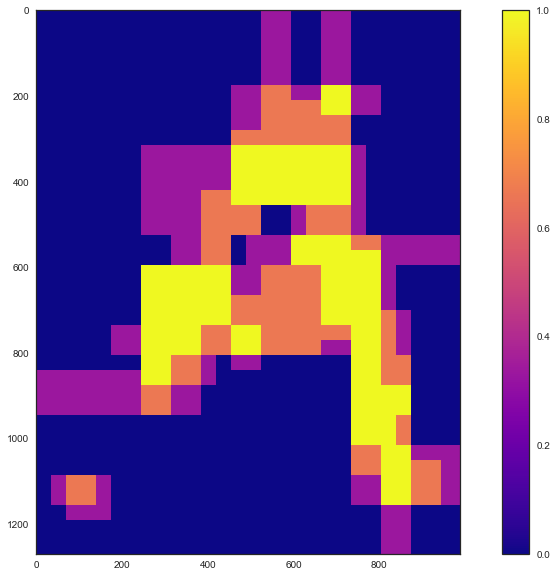

In [15]:
# Plot predictions
plt.figure(figsize=(15, 10))
dfgp = df_grid_m1.pivot('b', 'a', 'c_prob')
ax = plt.imshow(dfgp, interpolation='none', cmap='plasma')
cb = plt.colorbar()

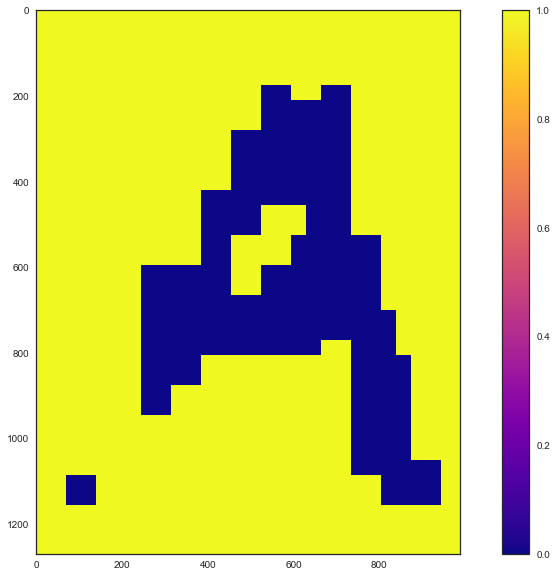

In [16]:
# Plot class
plt.figure(figsize=(15, 10))
dfgp = df_grid_m1.pivot('b', 'a', 'c')
ax = plt.imshow(dfgp, interpolation='none', cmap='plasma')
cb = plt.colorbar()

# SVM

In [17]:
from sklearn.svm import SVC

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

mapper = DataFrameMapper([
    # normalise if required
    (['a'], MinMaxScaler()),
    (['b'], MinMaxScaler()),
])

# mapper.fit_transform(df)

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('featurise', mapper),
    ('svm', SVC(kernel='sigmoid', C = 1.0, probability=True)),
])

model = pipeline.fit(x_train, y_train.values.ravel())
prediction = model.predict(x_test)
score = model.score(x_test, y_test)

display('{:.2%}'.format(score))
display(prediction)

# Get class 0 probabilities as c
df_grid_m2 = df_grid.copy()
df_grid_m2['c'] = model.predict(df_grid)
df_grid_m2['c_prob'] = model.predict_proba(df_grid)[:,0]
df_grid_m2


/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


'72.09%'

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

,a,b,c,c_prob
0,0.0,0.0,1,0.075472
1,0.1,0.0,1,0.075714
2,0.2,0.0,1,0.075957
3,0.3,0.0,1,0.076201
4,0.4,0.0,1,0.076446
...,...,...,...,...
1257295,98.5,126.9,1,0.009531
1257296,98.6,126.9,1,0.009465
1257297,98.7,126.9,1,0.009401
1257298,98.8,126.9,1,0.009336


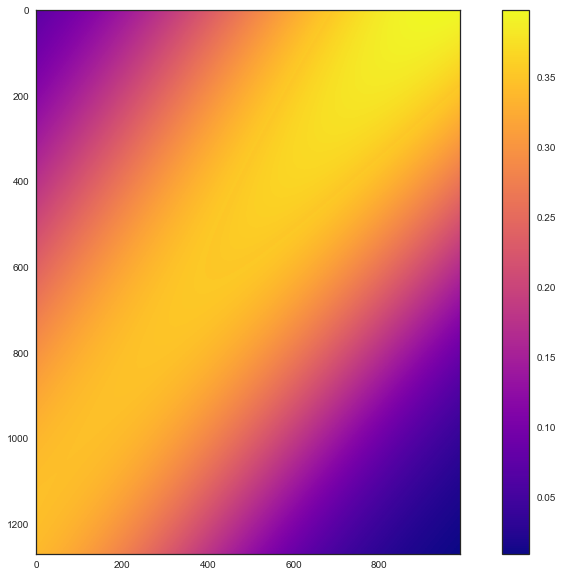

In [18]:
# Plot predictions
plt.figure(figsize=(15, 10))
dfgp = df_grid_m2.pivot('b', 'a', 'c_prob')
ax = plt.imshow(dfgp, interpolation='none', cmap='plasma')
cb = plt.colorbar()

# Gradient Boosting Classifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

mapper = DataFrameMapper([
    (['a'], MinMaxScaler()),
    (['b'], MinMaxScaler()),
])

pipeline = Pipeline([
    ('featurise', mapper),
    ('svm', GradientBoostingClassifier(n_estimators=50))
])

model = pipeline.fit(x_train, y_train.values.ravel())
prediction = model.predict(x_test)
score = model.score(x_test, y_test)

display('{:.2%}'.format(score))
display(prediction)

# Get class 0 probabilities as c
df_grid_m3 = df_grid.copy()
df_grid_m3['c'] = model.predict(df_grid)
df_grid_m3['c_prob'] = model.predict_proba(df_grid)[:,0]
df_grid_m3

/usr/local/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


'79.07%'

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

,a,b,c,c_prob
0,0.0,0.0,1,0.004313
1,0.1,0.0,1,0.004313
2,0.2,0.0,1,0.004313
3,0.3,0.0,1,0.004313
4,0.4,0.0,1,0.004313
...,...,...,...,...
1257295,98.5,126.9,1,0.016943
1257296,98.6,126.9,1,0.016943
1257297,98.7,126.9,1,0.016943
1257298,98.8,126.9,1,0.016943


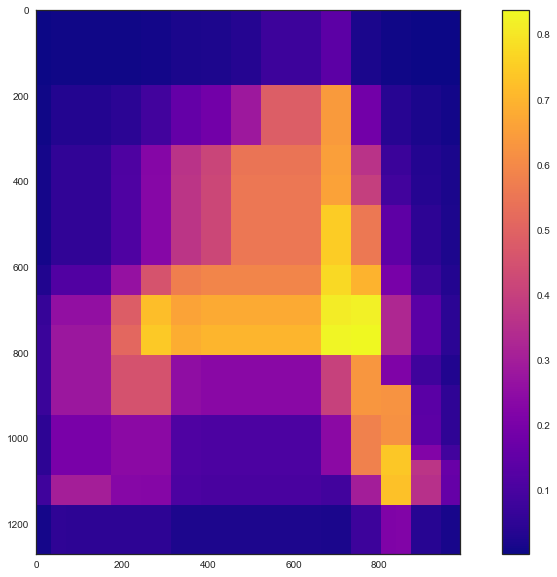

In [20]:
# Plot predictions
plt.figure(figsize=(15, 10))
dfgp = df_grid_m3.pivot('b', 'a', 'c_prob')
ax = plt.imshow(dfgp, interpolation='none', cmap='plasma')
cb = plt.colorbar()